# Home Credit Default Risk

You've been learning a lot about Machine Learning Algorithms, now we you're gonna be asked to put it all togheter. 

You will create a complete pipeline to preprocess the data, train your model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.


## 1. Introduction

This is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay their debt or not. Our model will have to predict a 1 indicating the client will have payment difficulties: he/she will have late payment of more than X days on at least one of the first Y installments of the loan in our sample, 0 in all other cases.

The dataset is composed of multiple files with different information about loans taken. In this project, we will work exclusively with the primary files: `application_train_aai.csv` and `application_test_aai.csv`.

We will use [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

In [99]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import StratifiedKFold

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src import config, data_utils, preprocessing

# my libraries >>

# %pip install imblearn    <--- install these
# %pip install lightgbm
# %pip install xgboost
# %pip install catboost

from imp import reload
import pickle
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from scipy.stats import randint
from catboost import CatBoostClassifier
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

### Getting the data

To access the data for this project, you only need to execute the code below. This will download three files inside the `dataset` folder:

- `application_train_aai.csv`: Training dataset you must use to train and find the best hyperparameters on your model.

- `application_test_aai.csv`: Test dataset without labels. Because of the absence of labels, you can't use this dataset for your experiments. You will use the file only at the end after you choose what you think is the best model for the tasks. You will have to use that model to fill values in the `TARGET` column using the model predictions. Then submit this dataset alongside this Jupyter notebook, AnyoneAI will internally evaluate your model's accuracy in the hidden data and communicate later ;).

- `HomeCredit_columns_description.csv`: This file contains descriptions for the columns in train and test datasets.


1.1. Load the training and test datasets. Also, the auxiliary file `HomeCredit_columns_description.csv` has additional information about the features in the dataset.

**Don't change anything in this cell, just make it run correctly**

In [30]:
app_train, app_test, columns_description = data_utils.get_datasets()


if app_train.shape == (246008, 122):
    print("Success: app_train shape is correct!")
else:
    raise ValueError("Train dataset shape is incorrect, please review your code")

if isinstance(app_train, pd.DataFrame):
    print("Success: app_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if app_test.shape == (61503, 122):
    print("Success: app_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(app_test, pd.DataFrame):
    print("Success: app_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Success: app_train shape is correct!
Success: app_train type is correct!
Success: app_test shape is correct!
Success: app_test type is correct!


### Exploratory Data Analysis

A lot of the analysis of the data can be found on publicly available Kaggle kernels or blog posts, but you need to make sure you understand the dataset's properties before starting working on it, so we'll do exploratory data analysis for the main files.

#### Dataset Basics

1.2. Print how many samples do we have in our train and test datasets.

In [31]:
### TODO Complete in this cell: shape of the dataset
print(f'train shape: {app_train.shape} test shape: {app_test.shape}')


train shape: (246008, 122) test shape: (61503, 122)


1.3. List all columns in the train dataset.

In [32]:
### TODO Complete in this cell: Show all columns in the training dataset
for i in app_train.columns:
    print(i)

SK_ID_CURR
TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
ORGANIZATION_TYPE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APART

1.4. Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

For reference only, it should look like this:

|0|1|2|3|4
|---|---|---|---|---
Unnamed: 0|187399|84777|268140|270686|33785
SK_ID_CURR|317244|198357|410700|413785|139141
TARGET|0|0|0|0|0
NAME_CONTRACT_TYPE|Cash loans|Cash loans|Cash loans|Cash loans|Cash loans
...|...|...|...|...|...
AMT_REQ_CREDIT_BUREAU_DAY|0.0|0.0|0.0|0.0|0.0

In [33]:
### TODO Complete in this cell: show first 5 records in a transposed table
app_train.head(5).T

,0,1,2,3,4
SK_ID_CURR,428247,140966,407283,434300,446788
TARGET,0,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,F,M,F,F,F
FLAG_OWN_CAR,N,Y,N,N,N
...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,NaN,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_WEEK,NaN,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_MON,NaN,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_QRT,NaN,0.0,0.0,1.0,0.0


1.5. Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

In [34]:
summary = pd.DataFrame({
    'Counts': app_train['TARGET'].value_counts(),
    'Percentage':app_train['TARGET'].value_counts(normalize=True).apply(lambda x: round(x*100,2))
}).reset_index()
summary

,index,Counts,Percentage
0,0,226257,91.97
1,1,19751,8.03


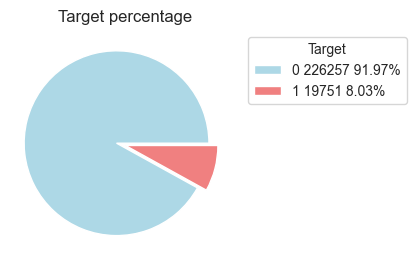

In [35]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

# pie data
wedges, autotexts = ax.pie(summary['Percentage'], explode = (0.1, 0),colors = ['lightblue', 'lightcoral'])
labels = summary['index'].astype(str) + ' ' + summary['Counts'].astype(str) + ' ' + summary['Percentage'].astype(str) + '%'
ax.legend(wedges, labels,
          title="Target",
          bbox_to_anchor=(1, 0, 0.5, 1)
        )

plt.setp(autotexts, size=8)

ax.set_title("Target percentage")

plt.show()

1.6. Show the number of columns of each data type.

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
float64    45
int64      32
object     10
```

In [36]:
### TODO Complete in this cell: show number of columns per data type
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

1.7. For categorical variables (`object` data type), show the number of distinct values in each column (number of labels).

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
NAME_CONTRACT_TYPE             5
CODE_GENDER                    2
FLAG_OWN_CAR                   1
FLAG_OWN_REALTY                1
...
```

In [37]:
### TODO Complete in this cell: show number of unique values per categorical column
obj_columns = app_train.select_dtypes(include='object').columns
count_categories_bytype = app_train[obj_columns].nunique()
count_categories_bytype



NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

1.8. Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

Just for giving you an idea, the output should look like this (not exactly the same numbers and columns names):

```python
                   Total   Percent
COMMONAREA_AVG    121000      85.2
COMMONAREA_MODE   121000      76.6
COMMONAREA_MEDI   121000      62.9
...
```

In [38]:
mz_table = pd.concat([app_train.isnull().sum(), round(100 * app_train.isnull().sum() / len(app_train), 1)], axis=1)
mz_table = mz_table.rename(columns = {0 : 'Total', 1 : 'Percent'})
mz_table.sort_values(by='Percent', ascending=False).head(20)

,Total,Percent
COMMONAREA_MEDI,172189,70.0
COMMONAREA_AVG,172189,70.0
COMMONAREA_MODE,172189,70.0
NONLIVINGAPARTMENTS_MODE,171096,69.5
NONLIVINGAPARTMENTS_AVG,171096,69.5
NONLIVINGAPARTMENTS_MEDI,171096,69.5
LIVINGAPARTMENTS_MODE,168494,68.5
LIVINGAPARTMENTS_AVG,168494,68.5
FONDKAPREMONT_MODE,168561,68.5
LIVINGAPARTMENTS_MEDI,168494,68.5


#### Analyzing distribution of variables

1.9. Show the distribution of credit amounts.

*Hint:* Take a look at `AMT_CREDIT` column.

In [39]:
app_train['AMT_CREDIT'].describe()

count    2.460080e+05
mean     5.991707e+05
std      4.034845e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.124465e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

<AxesSubplot: xlabel='AMT_CREDIT', ylabel='Count'>

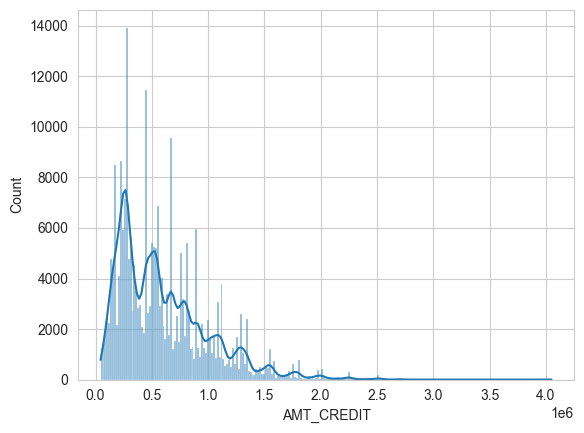

In [40]:
### TODO Complete in this cell: distribution of credit amounts
sns.set_style('whitegrid')
sns.histplot(app_train['AMT_CREDIT'],kde = True)

1.10. Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

*Hint:* Take a look at `NAME_EDUCATION_TYPE` column.

In [41]:
### TODO Complete in this cell: level of education plot
total_rows = app_train.shape[0]
ed_counts =  pd.DataFrame(app_train['NAME_EDUCATION_TYPE'].value_counts()).reset_index()
ed_counts.columns = ['education_level', 'count']
ed_counts['percentage'] = ed_counts['count'].apply(lambda x: round((x/total_rows)*100,2))
ed_counts




,education_level,count,percentage
0,Secondary / secondary special,174657,71.00
1,Higher education,59990,24.39
2,Incomplete higher,8248,3.35
3,Lower secondary,2984,1.21
4,Academic degree,129,0.05


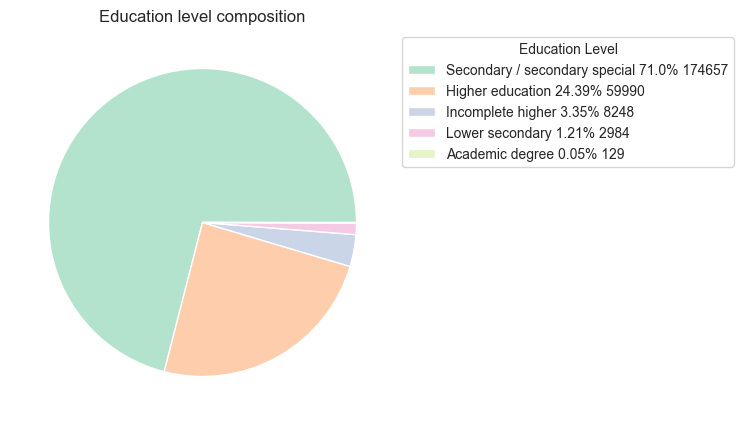

In [42]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))

# pie data
wedges, autotexts = ax.pie(ed_counts['percentage'],colors=sns.color_palette("Pastel2", len(ed_counts)))
labels = ed_counts['education_level'].astype(str) + ' ' + ed_counts['percentage'].astype(str) + '%' + ' ' + ed_counts['count'].astype(str)
ax.legend(wedges, labels,
          title="Education Level",
          bbox_to_anchor=(1, 0, 0.5, 1)
        )

plt.setp(autotexts, size=8)

ax.set_title("Education level composition")

plt.show()

1.11. Plot the distribution of ocupation of the loan applicants.

*Hint:* Take a look at `OCCUPATION_TYPE` column.

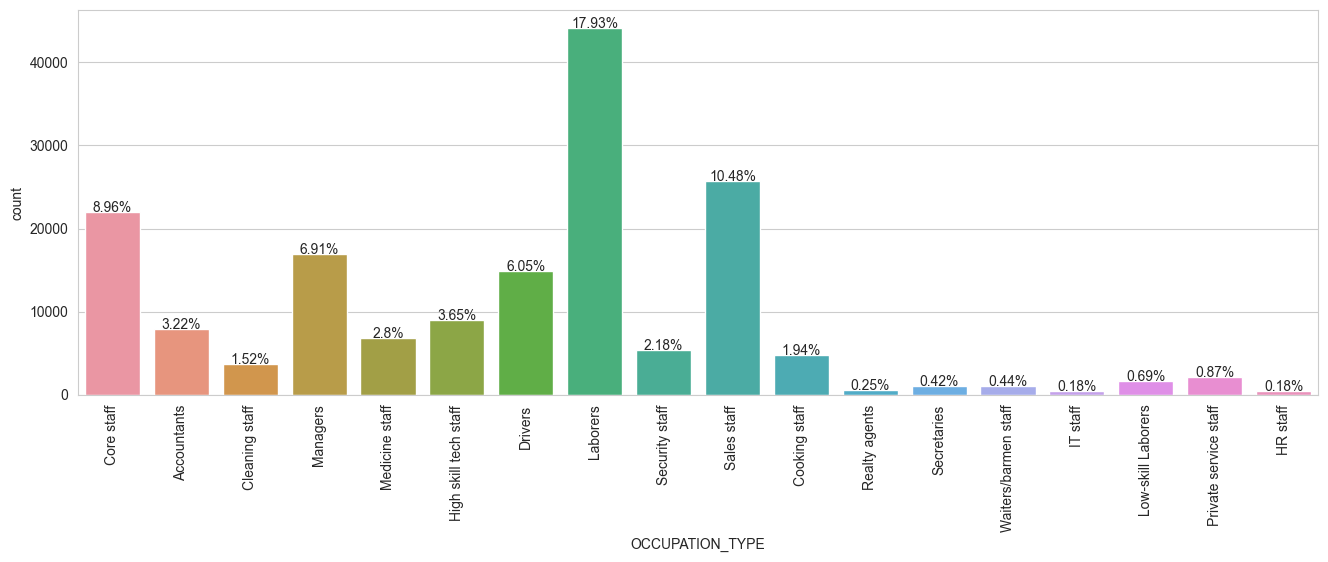

In [43]:
### TODO Complete in this cell: ocupation of applicants
fig = plt.figure(figsize = (16,5))
ax = sns.countplot(x = app_train['OCCUPATION_TYPE'])
plt.xticks(rotation = 90)

for p in ax.patches:
    ax.annotate(f'{round((p.get_height()/total_rows)*100,2)}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
plt.show()

1.12. Plot the family status of the applicants.

*Hint:* Take a look at `NAME_FAMILY_STATUS` column.

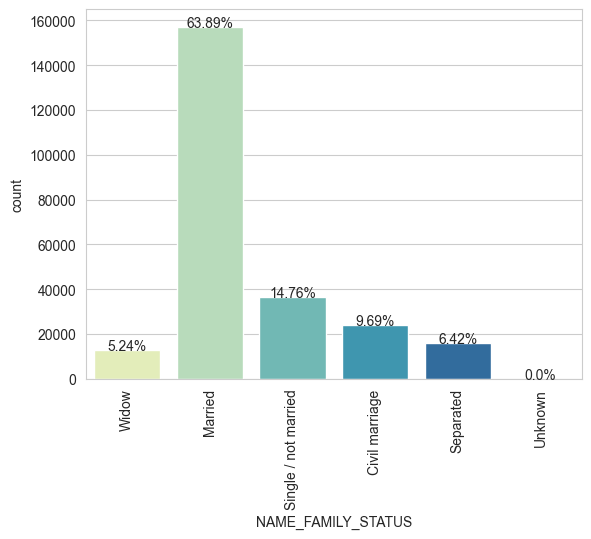

In [44]:
### TODO Complete in this cell: family status
ax = sns.countplot(x = app_train['NAME_FAMILY_STATUS'],palette = 'YlGnBu')
plt.xticks(rotation = 90)

for p in ax.patches:
    ax.annotate(f'{round((p.get_height()/total_rows)*100,2)}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
plt.show()

1.13. Plot the income type of applicants grouped by the target variable.

*Hint:* Take a look at `NAME_INCOME_TYPE` and `TARGET` columns. You can use `hue` parameter on Seaborn to group samples using another categorical feature.

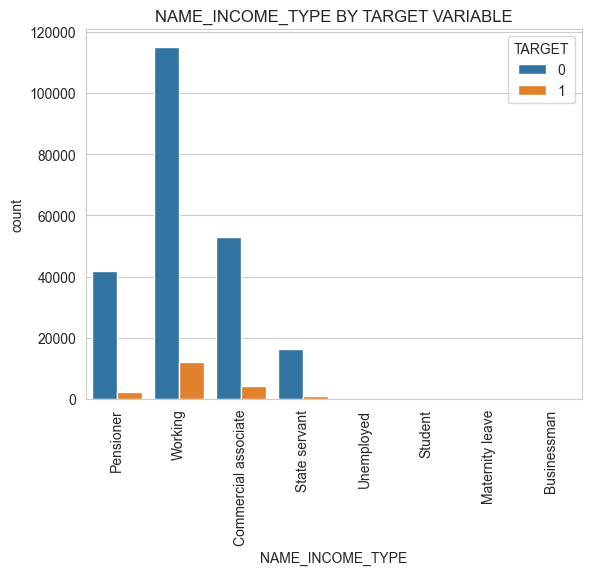

In [45]:
### TODO Complete in this cell: Income type of applicants by target variable
ax = sns.countplot(data = app_train, x= 'NAME_INCOME_TYPE', hue= 'TARGET')
plt.title('NAME_INCOME_TYPE BY TARGET VARIABLE')
plt.xticks(rotation = 90)
plt.show()

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{round((height/total_rows)*100, 2)}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='baseline', xytext=(0, 10),  # Adjust the y-coordinate with xytext
                textcoords='offset points')


## 2. Preprocessing

2.1. The next step will be to separate our train and test datasets columns between Features (the input to the model) and Targets (what the model has to predict with the given features).

- Assign to `X_train` all the columns from `app_train` that should be used as features for training our models.
- Assign to `y_train` the single column from `app_train` that should be used as our target (i.e. what we want to predict).
- Assign to `X_test` all the columns from `app_test` that should be used as features for training our models.
- Assign to `y_test` the single column from `app_test` that should be used as our target (i.e. what we want to predict).

To do that, you will have to complete the function `data_utils.get_feature_target()` in all the parts with a `TODO` mark.


**Don't change anything in this cell, just make it run correctly**

In [46]:
# Now we execute the function above to get the result
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)


if X_train.shape == (246008, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (246008,) or y_train.shape == (246008, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_test.shape == (61503, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_test, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_test.shape == (61503,) or y_test.shape == (61503, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


2.2. In order to avoid overfitting while searching for the best model hyperparameters, it's always a good idea to split our training dataset into two new sets called `train` and `validation`. 

While the `train` data will be used to fit the model and adjust its internal weights, the `validation` will be exclusively used to test the model performance on unseen data during training, it's like a testing dataset used during experimentation.

Remember we can't use the `test` dataset to validate the model performance because this one lacks of labels :( So the `validation` data will be the only resource you will have to evaluate the final model performance before doing your submission.

To do that, you will have to complete the function `data_utils.get_train_val_sets()` in all the parts with a `TODO` mark.

This function should perform these activities:
- Use the `sklearn.model_selection.train_test_split` function with `X_train`, `y_train` datasets.
- Assign only 20% of the dataset for testing (see `test_size` parameter in `train_test_split`)
- Assign a seed so we get reproducible output across multiple function calls (see `random_state` parameter in `train_test_split`)
- Shuffle the data (see `shuffle` parameter in `train_test_split`)

For reference, see:
- [Scikit-learn train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [Wikipedia: Training, validation, and test data sets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets)
- [Train Test Validation Split: How To & Best Practices](https://www.v7labs.com/blog/train-validation-test-set)


**Don't change anything in this cell, just make it run correctly**

In [47]:
# Now we execute the function above to get the result
reload(data_utils)
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)


if X_train.shape == (196806, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (196806,) or y_train.shape == (196806, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_val.shape == (49202, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_val, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_val.shape == (49202,) or y_val.shape == (49202, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


2.3. In this section, you will code a function to make all the data pre-processing for the dataset. What you have to deliver is a function that takes `X_train`, `X_val`, and `X_test` dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function should perform these activities, in this order:

1. Correct outliers/anomalous values in numerical columns (`DAYS_EMPLOYED` column)
2. Encode string categorical features (dytpe `object`):
    - If the feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
3. Impute values for all columns with missing data (use median as imputing value)
4. Feature scaling with Min-Max scaler.

Complete the function `preprocessing.preprocess_data()` following the instructions given above.

In the following cell, we are going to execute the preprocessing function you've just coded. No need to modify this.

**Important Note:** From now on, you must always use `train_data` for training your models and `val_data` only for the final evaluation of the model trained. About `test_data`, it will be used at the end only for submitting your final model predictions and be evaluated on our side with the hidden annotations.


**Don't change anything in this cell, just make it run correctly**

In [48]:
reload(preprocessing)
train_data, val_data, test_data = preprocessing.preprocess_data(X_train, X_val, X_test)

if train_data.shape == (196806, 246):
    print("Success: train_data shape is correct!")
else:
    raise ValueError("train_data dataset shape is incorrect, please review your code")

if isinstance(train_data, np.ndarray):
    print("Success: train_data type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if val_data.shape == (49202, 246):
    print("Success: val_data shape is correct!")
else:
    raise ValueError("val_data dataset shape is incorrect, please review your code")

if isinstance(val_data, np.ndarray):
    print("Success: val_data type is correct!")
else:
    raise ValueError("Validation dataset type is incorrect, please review your code")

if test_data.shape == (61503, 246):
    print("Success: test_data shape is correct!")
else:
    raise ValueError("test_data dataset shape is incorrect, please review your code")

if isinstance(test_data, np.ndarray):
    print("Success: test_data type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Success: train_data shape is correct!
Success: train_data type is correct!
Success: val_data shape is correct!
Success: val_data type is correct!
Success: test_data shape is correct!
Success: test_data type is correct!


_____________


## 3. Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

**Pro tip:** It is of utmost importance to make an accurate estimation of the time required to train a machine learning model. Because of this, we recommend you to use Python [time](https://docs.python.org/3/library/time.html) library or Jupyter magic function `%%time` on the cell you're training your model to get an estimate of the time it took to fit your data.

### Baseline: LogisticRegression

3.1. Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter.

Assign the trained model to `log_reg` variable.

**Don't change anything in this cell, just make it run correctly**

In [94]:

# This is an example code on how to:
#   - Create and fit (train) a logistic regression
#   - Assign to `log_reg` variable
log_reg = None
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train_data, y_train)

CPU times: total: 6 s
Wall time: 1.41 s


LogisticRegression(C=0.0001)

**Don't change anything in this cell, just make it run correctly**

In [95]:
if isinstance(log_reg, LogisticRegression):
    print("Success: Logistic regression model type is correct!")
else:
    raise ValueError(
        "Logistic regression model type is incorrect, please review your code"
    )

check_is_fitted(log_reg)

Success: Logistic regression model type is correct!


3.2. Use the trained model to predict probabilities for `train_data` and `val_data`.

**Important note:** When using the function `predict_proba()` for getting model probabilities you will get, for each sample, a tuple indicating the probability for class 0 and for class 1 respectively. For computing the AUC ROC score we only need the probability that the debt is not repaid (equivalent to class 1). As an example, the result from running `predict_proba()` on validation dataset will have a shape of `(49202, 2)` but, we only need the second column from that matrix, which corresponds to the class 1.


**Don't change anything in this cell, just make it run correctly**

In [96]:
# Example code to show you how to use the Logistic Regression model
# to predict probabilities for each class and then, use the probabilities for the
# class 1 only.

# Train data predictions (class 1)
log_reg_train = log_reg.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
log_reg_val = log_reg.predict_proba(val_data)[:, 1]

3.3. Get AUC ROC score on train and validation datasets. See [scikit-learn AUC ROC function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for a working implementation.

Assign the AUC ROC score to `lr_roc_auc` variable.


**Don't change anything in this cell, just make it run correctly**

In [97]:
# Example code to show you how to get the ROC AUC Score on train and val datasets

# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=log_reg_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")



Train ROC AUC Score: 0.7440
Validation ROC AUC Score: 0.7414


At this point, the model should produce a result of around 0.67.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

**Don't change anything in this cell, just make it run correctly**

In [26]:
if isinstance(roc_auc_val, float):
    print("Success: AUC ROC score type is correct!")
else:
    raise ValueError("AUC ROC score type is incorrect, please review your code")

if roc_auc_val >= 0.6:
    print("Success: AUC ROC score is correct!")
else:
    raise ValueError("AUC ROC score is incorrect, please review your code")

Success: AUC ROC score type is correct!
Success: AUC ROC score is correct!


### Training a Random Forest Classifier 

You're gonna start working in more complex models: ensambles, particularly, you're going to use the Random Forest Classifier from Scikit Learn. 

3.4. Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for `n_jobs`, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [62]:
# TODO Write your code here for training a Random Forest model.
#   - Please use sklearn.ensemble.RandomForestClassifier() class.
#   - Assign the model to the variable `rf`.
#   - Remember to fit the model only on `train_data`.
rf = RandomForestClassifier(min_samples_split= 4, n_jobs=-1)
rf.fit(train_data,y_train)


CPU times: total: 3min 45s
Wall time: 33.3 s


RandomForestClassifier(min_samples_split=4, n_jobs=-1)

**Don't change anything in this cell, just make it run correctly**

In [158]:
if isinstance(rf, RandomForestClassifier):
    print("Success: RandomForestClassifier model type is correct!")
else:
    raise ValueError(
        "RandomForestClassifier model type is incorrect, please review your code"
    )

check_is_fitted(rf)

Success: RandomForestClassifier model type is correct!


3.5. Use the classifier to predict probabilities for `train_data` and `val_data`.

In [159]:
# TODO Use the Random Forest model to predict probabilities for each class and then,
# use the probabilities for the class 1 only.

# Train data predictions (class 1)
rf_pred_train = rf.predict_proba(train_data)[:,1]

# Validation data predictions (class 1)
rf_pred_val = rf.predict_proba(val_data)[:,1]

3.6. Get AUC ROC score on train and validation datasets.


In [160]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_train,rf_pred_train)

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_val, rf_pred_val)
print(f'roc_train: {roc_auc_train} roc_val {roc_auc_val}')

roc_train: 1.0 roc_val 0.709967087264903


At this point, the model should produce a result around 0.7.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?
it's not showing signals of being overfitted however the model can be significantly improved, let's test another models with other approaches 


--------------

### Randomized Search with Cross Validation

So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section you trained a random forest classifier and saw how much it took to train it once in your PC. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


3.7. Use `sklearn.model_selection.RandomizedSearchCV()` to find the best combination of hyperparameters for a Random Forest model. 

The validation metric used to evaluate the models should be "roc_auc" (i.e. `scoring="roc_auc"`).

In [ ]:
#%%time
# TODO Write your code here for training a Random Forest model using Random Search
# of hyper-parameters.
#   - Please use sklearn.model_selection.RandomizedSearchCV() and
#     sklearn.ensemble.RandomForestClassifier() classes.
#   - Assign the RandomizedSearchCV model to the variable `rf_random`.
#   - Remember to fit the model only on `train_data`.
# rf_random = RandomizedSearchCV(estimator= RandomForestClassifier(),param_distributions= params,n_jobs=-1)

params = { 
        'n_estimators': [100,150,200,300], 
        'max_depth': [3,5,7,9,11,13,15],
        'min_samples_split': np.arange(2,18,2),
        'min_samples_leaf': np.arange(1,11,2),
        'bootstrap': [True,False],
        }
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_random = RandomizedSearchCV(estimator= RandomForestClassifier(),cv = cv, param_distributions= params,n_jobs=-1)
rf_random.fit(train_data,y_train)
print(f'best estimators: \n {rf_random.best_estimator_} \nbest params: {rf_random.best_params_}')

rforest_model = rf_random.best_estimator_
# save the model into a pickle 
with open('best_random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_random.best_estimator_, file)

# undersampling
# https://imbalanced-learn.org/stable/under_sampling.html

3.8. Use the classifier to predict probabilities on the train and test data.

&

3.9. Get AUC ROC score on train and validation datasets.


In [24]:
# TODO Use the RandomizedSearchCV model to predict probabilities for each class and
# then, use the probabilities for the class 1 only.

def test_model(model):
    y_pred_train = model.predict(train_data)
    y_pred_val = model.predict(val_data)

    y_pred_proba_train = model.predict_proba(train_data)[:,1]
    y_pred_proba_val = model.predict_proba(val_data)[:,1]

    results = {'roc_train': roc_auc_score(y_train,y_pred_proba_train),
            'roc_val': roc_auc_score(y_val,y_pred_proba_val),
            'accuracy_train': accuracy_score(y_train,y_pred_train),
            'accuracy_val': accuracy_score(y_val,y_pred_val),
            'precision_train': accuracy_score(y_train,y_pred_train),
            'precision_val': accuracy_score(y_val,y_pred_val),
            'recall_train': accuracy_score(y_train,y_pred_train),
            'recall_val': accuracy_score(y_val,y_pred_val),
            'f1_score_train': f1_score(y_train,y_pred_train),
            'f1_score_val': f1_score(y_val,y_pred_val)
          }

    summary = pd.DataFrame.from_dict(results,orient = 'index')
    return summary

summary = test_model(rforest_model)
summary


At this point, the model should produce a result around 0.7 or higher.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

## 4. Predict unlabeled data

Now it's time to finally use the `test_data` samples. Because we don't have the labels we can't see how the model performs on this dataset (╯°□°)╯︵ ┻━┻

But... don't worry, we will internally evaluate your model and give feedback on the results!

In the cells below:
- Take your best model
- Take `test_data` (i.e. the dataset after doing the preprocessing and feature engineering part)
- Run the data through your model and save the predictions on the `TARGET` column in the `app_test` DataFrame (yeah that we've loaded at the very beginning of this notebook).
    - `TARGET` column values must be the probabilities for class 1. So remember to use the `predict_proba()` function from your model as we did in the previous sections.
- Save the modified version of the DataFrame with the same name it has before (`dataset/application_test_aai.csv`) and don't forget to submit it alongside the rest of this sprint project code
- And finally, don't get confused, you shouldn't submit `dataset/application_train_aai.csv`. So please don't upload your solution with this heavy dataset inside.

Let's say your best model is called `best_credit_model_ever`, then your code should be exactly this:

```python
    test_preds = best_credit_model_ever.predict_proba(test_data)[:, 1]
    app_test["TARGET"] = test_preds
    app_test.to_csv(config.DATASET_TEST, index=False)
```


In [ ]:
%%time

# TODO Use your best model and call the predict_proba() on test_data then,
# use the probabilities for the class 1 only.
# Then, put the predictions in app_test["TARGET"] and save the DataFrame as a csv
# with the same name it originally has ("application_test_aai.csv").



## 5. Optional exercises

### Optional: Training a LightGBM model 

5.1. Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. You can try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained. 

In [66]:
### Complete in this cell: train a LightGBM model
lgbm_model = LGBMClassifier(
    learning_rate = 0.05,
    boosting_type = 'dart',
    objective = 'binary',
    metric = ['auc','binary_logloss'],
    num_leaves =100,
    max_depth = 12,
    scale_pos_weight =1
)
lgbm_model.fit(train_data,y_train)

# strategy: use the parameter scale_pos_weight,   randomizedcV with learning rate, num_leaves, max_depth, (including default parameters of num_leaves and max_depth)
# try variations in preprocessing, use standardscaler, under sampling or oversampling,

[LightGBM] [Info] Number of positive: 15784, number of negative: 181022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11666
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080201 -> initscore=-2.439622
[LightGBM] [Info] Start training from score -2.439622


In [93]:
summary = test_model(lgbm_model)
summary

,0
roc_train,0.789463
roc_val,0.745350
accuracy_train,0.920399
accuracy_val,0.919394
precision_train,0.920399
precision_val,0.919394
recall_train,0.920399
recall_val,0.919394
f1_score_train,0.016202
f1_score_val,0.007011


In [ ]:
# randomized search ligthgbm model
params = { 
    'learning_rate': [0.1, 0.05, 0.025],
    'boosting_type': ['dart'],
    'objective': ['binary'],
    'metric':['auc','binary_logloss'],
    'num_leaves':[31,40,50,60,70,80,90,100,120,130,140,150],
    'max_depth':[-1,5,6,7,8,9,10,12,15,20],
    'scale_pos_weight': [1,4]
    }
lgbm_randomscv = RandomizedSearchCV(
    estimator= LGBMClassifier(), 
    param_distributions= params,
    n_jobs=-1, random_state = 42,
    cv = 5, n_iter= 200)
lgbm_randomscv.fit(train_data,y_train)

with open('lgbm_model_rscv3.pkl','wb') as file:
    pickle.dump(lgbm_randomscv.best_estimator_,file)

### Evaluate performance

In [90]:
summary = test_model(lgbm_randomscv.best_estimator_)
summary

,0
roc_train,0.522533
roc_val,0.525077
accuracy_train,0.901654
accuracy_val,0.901041
precision_train,0.901654
precision_val,0.901041
recall_train,0.901654
recall_val,0.901041
f1_score_train,0.033458
f1_score_val,0.036795


In [89]:
## for single model
y_pred_train_proba = lgbm_model.predict(train_data)
y_pred_val_proba = lgbm_model.predict(val_data)

# # for rscv model
# y_pred_train_proba = lgbm_model.predict_proba(train_data)[:,1]
# y_pred_val_proba = lgbm_model.predict_proba(val_data)[:,1]

print(f'roc_auc_train: {roc_auc_score(y_train,y_pred_train_proba)} roc_auc_val: {roc_auc_score(y_val,y_pred_val_proba)}')

roc_auc_train: 0.5225330086197587 roc_auc_val: 0.5250766625032331


In [163]:
## from single model, transform prob to label
def transform_proba_to_label(x):
    return 1 if x >= 0.5 else 0
y_pred_train = np.array(list(map(transform_proba_to_label,y_pred_train_proba)))
y_pred_val = np.array(list(map(transform_proba_to_label,y_pred_val_proba)))



In [164]:
# y_pred_train = lgbm_model.predict(train_data)
# y_pred_val = lgbm_model.predict(val_data)

print('Train data: \n')
print(f'accuracy_score_train {accuracy_score(y_train,y_pred_train)}')
print(f'precision_score_train {precision_score(y_train,y_pred_train)}')
print(f'recall_score_train {recall_score(y_train,y_pred_train)}')
print(f'f1_score_train {f1_score(y_train,y_pred_train)}')
print('Val data \n')
print(f'accuracy_score_val {accuracy_score(y_val,y_pred_val)}')
print(f'precision_score_val {precision_score(y_val,y_pred_val)}')
print(f'recall_score_val {recall_score(y_val,y_pred_val)}')
print(f'f1_score_val {f1_score(y_val,y_pred_val)}')

Train data: 

accuracy_score_train 0.9202768208286333
precision_score_train 0.944
recall_score_train 0.0074678817796342
f1_score_train 0.0148185357277408
Val data 

accuracy_score_val 0.9199829275232714
precision_score_val 0.76
recall_score_val 0.004810126582278481
f1_score_val 0.009559748427672956


### Optional: Using Scikit Learn Pipelines 

5.2. So far you've created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and you don't want to have to remember the correct steps to follow each time you have new data to train your models. There are a lots of tools out there that can help you with that, here you can use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process your data.

In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split

### Complete in this cell: use a sklearn Pipeline to automate the cleaning, standardizing and training

# split into target and data
X = app_train.drop(columns='TARGET')
y = app_train.loc[:,'TARGET']

# define column types

obj_cols = list(X.dtypes[X.dtypes == 'object'].index)
num_cols = [col for col in X.columns if col not in obj_cols ]
bin_cols = [col for col in obj_cols if X[col].nunique()== 2]
cat_cols = [col for col in obj_cols if col not in bin_cols]

# split the data:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size= 0.2,shuffle= True)

# categoric: binary y multicat
num_transformer = Pipeline( 
    steps = [('imputer',SimpleImputer(strategy='median')),
             ('scaler',StandardScaler()) 
    ]
)
category_transformer = Pipeline(
    steps = [
        ('one_hot', OneHotEncoder()),
        ('imputer',SimpleImputer(strategy='median'))
    ]
)
binary_transformer = Pipeline(
    steps = [
        ('one_hot', OrdinalEncoder()),
        ('imputer',SimpleImputer(strategy='median'))
    ]
)

preprocessor = ColumnTransformer(
    [('categorical',category_transformer,cat_cols),
     ('binary',binary_transformer,bin_cols),
     ('numeric',num_transformer,num_cols)
    ]
)

params = { 
        'rf_model__n_estimators': [100], 
        'rf_model__max_depth': [5],
        'rf_model__min_samples_split': [4],
        'rf_model__min_samples_leaf': [3],
        'rf_model__bootstrap': [True]
        }
estimator = RandomForestClassifier()

rfmodel_pipe = Pipeline(
    steps=[
        ('pre_proccesor',preprocessor),
        ('rf_model', estimator )
    ]
)

rnd_searchcv_rf = RandomizedSearchCV(rfmodel_pipe,params,cv=5,scoring='roc_auc',n_jobs=-1)
rnd_searchcv_rf.fit(X_train,y_train)

c:\Users\user\Desktop\AnyoneAI\SPR02\sprint02venv\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\user\Desktop\AnyoneAI\SPR02\sprint02venv\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pre_proccesor',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('one_hot',
                                                                                                OneHotEncoder()),
                                                                                               ('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['CODE_GENDER',
                                                                                'NAME_TYPE_SUITE',
                                                                                'NAME_INCOME_TYPE',
                                                                                'NAME_EDUCATION_TYPE',
                                                                                'NAME_FAMILY_STATUS',
                                                                                'NAME_HOUSING_TYPE',
                                                                                'OCCUPATION_TYPE',
                                                                                'WEEKDAY_APP...
                                                                                'REG_CITY_NOT_LIVE_CITY',
                                                                                'REG_CITY_NOT_WORK_CITY',
                                                                                'LIVE_CITY_NOT_WORK_CITY',
                                                                                'EXT_SOURCE_1',
                                                                                'EXT_SOURCE_2', ...])])),
                                             ('rf_model',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'rf_model__bootstrap': [True],
                                        'rf_model__max_depth': [5],
                                        'rf_model__min_samples_leaf': [3],
                                        'rf_model__min_samples_split': [4],
                                        'rf_model__n_estimators': [100]},
                   scoring='roc_auc')

In [84]:
myrf_model = rnd_searchcv_rf.best_estimator_


rf_pred_train = myrf_model.predict_proba(X_train)[:,1]
rf_pred_val = myrf_model.predict_proba(X_val)[:,1]


roc_auc_train = roc_auc_score(y_train,rf_pred_train)

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_val, rf_pred_val)
print(f'roc_train: {roc_auc_train} roc_val {roc_auc_val}')



roc_train: 0.7308085544018912 roc_val 0.7154613133076567


### Optional: Build your own model and features

5.3. If you want you can take the original labeled data given and make your own feature selection, data preprocessing, and model tunning. Be creative, the only limit is time and hardware resources. Only be careful and don't modify the previous functions made in the mandatory assignments or, you will break the project tests.

You can even use this newer model to make predictions in the test dataset with hidden labels and submit that.


#### experimenting with under sampling

In [96]:
### Complete in this cell: Make you own experimentation process
from imblearn.under_sampling import RandomUnderSampler

# train_data y val_data . make undersampling 
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

rus = RandomUnderSampler(random_state= 42)
train_data_us, y_train_us = rus.fit_resample(train_data,y_train)

print(y_train_us.value_counts())
print(y_train_us.value_counts(normalize=True))

### ensamble de lightgbm,xgboost (investigar que modelo fué el que ganó el kaggle )

0    180969
1     15837
Name: TARGET, dtype: int64
0    0.91953
1    0.08047
Name: TARGET, dtype: float64
0    15837
1    15837
Name: TARGET, dtype: int64
0    0.5
1    0.5
Name: TARGET, dtype: float64


#### base line lgbm model 


In [98]:
# train a lightgbm model with this data
d_train = lgb.Dataset(data = train_data_us,label = y_train_us)
lgbm_params = {
    'learning_rate': 0.05,
    'boosting_type': 'dart',
    'objective': 'binary',
    'metric':['auc','binary_logloss'],
    'num_leaves':100,
    'max_depth':12,
    'scale_pos_weight':1
}
lgbm_model_us = lgb.train(lgbm_params,d_train,100)


[LightGBM] [Info] Number of positive: 15837, number of negative: 15837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10951
[LightGBM] [Info] Number of data points in the train set: 31674, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [100]:
y_pred_train_us = lgbm_model_us.predict(train_data)
y_pred_val_us = lgbm_model_us.predict(val_data)

y_pred_train_us = np.array(list(map(transform_proba_to_label,y_pred_train_us)))
y_pred_val_us = np.array(list(map(transform_proba_to_label,y_pred_val_us)))

print(f'roc_auc_train: {roc_auc_score(y_train,y_pred_train_us)} roc_auc_val: {roc_auc_score(y_val,y_pred_val_us)}')

print('Train data: \n')
print(f'accuracy_score_train {accuracy_score(y_train,y_pred_train_us)}')
print(f'precision_score_train {precision_score(y_train,y_pred_train_us)}')
print(f'recall_score_train {recall_score(y_train,y_pred_train_us)}')
print(f'f1_score_train {f1_score(y_train,y_pred_train_us)}')
print('Val data \n')
print(f'accuracy_score_val {accuracy_score(y_val,y_pred_val_us)}')
print(f'precision_score_val {precision_score(y_val,y_pred_val_us)}')
print(f'recall_score_val {recall_score(y_val,y_pred_val_us)}')
print(f'f1_score_val {f1_score(y_val,y_pred_val_us)}')

roc_auc_train: 0.6446384668539288 roc_auc_val: 0.5025127380980428
Train data: 

accuracy_score_train 0.5555318435413554
precision_score_train 0.12461878661482514
recall_score_train 0.7508366483551178
f1_score_train 0.21375925792766232
Val data 

accuracy_score_val 0.511930409332954
precision_score_val 0.08030568779754448
recall_score_val 0.49131323454266734
f1_score_val 0.1380473797559225


#### XGBOOST base model 


In [59]:
# base line xgboost model
xgb_model = XGBClassifier(random_state = 42)
xgb_model.fit(train_data,y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [49]:
print('xgboost baseline model performance:')
summary = test_model(xgb_model)
summary

xgboost baseline model performance:


,0
roc_train,0.865655
roc_val,0.744194
accuracy_train,0.925475
accuracy_val,0.918540
precision_train,0.925475
precision_val,0.918540
recall_train,0.925475
recall_val,0.918540
f1_score_train,0.155273
f1_score_val,0.059155


my models for ensembling:
* light gbm
* xgboost
* catboost (too heavy) replaced with logistic regression

#### additional feature enginneering


In [53]:
app_train_copy = app_train.copy()
list_empty_cols = []
for col in app_train_copy.columns:
    if (app_train_copy[col].isnull().sum()/len(app_train_copy)) > 0.5:
        list_empty_cols.append(col)
print(len(app_train_copy.columns))
app_train_copy.drop(columns= list_empty_cols,inplace= True)
print(len(app_train_copy.columns))

122
81


In [54]:
# preprocessing the data again
X_train = app_train.drop(columns = 'TARGET')
y_train = app_train.loc[:,'TARGET']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, shuffle=True,random_state=42)
train_data, val_data, test_data = preprocessing.preprocess_data(X_train, X_val, X_test)

In [106]:
xgb_model = XGBClassifier(random_state = 42)
xgb_model.fit(train_data,y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [107]:
print('xgboost baseline model performance with columns cleaning:')
summary = test_model(xgb_model)
summary

xgboost baseline model performance with columns cleaning:


,0
roc_train,0.865655
roc_val,0.744194
accuracy_train,0.925475
accuracy_val,0.918540
precision_train,0.925475
precision_val,0.918540
recall_train,0.925475
recall_val,0.918540
f1_score_train,0.155273
f1_score_val,0.059155


### XGB classifier tuned

In [66]:
# ready
from sklearn.model_selection import RepeatedStratifiedKFold

param_dist_xg = {
    'objective': ['binary:logistic'],
    'scale_pos_weight': randint(1, 100),  # Rango para scale_pos_weight
    'subsample': np.arange(0.1, 1.1, 0.1),  # Valores de subsample de 0.1 a 1.0 con incrementos de 0.1
    'colsample_bytree': np.arange(0.1, 1.1, 0.1),  # Valores de colsample_bytree de 0.1 a 1.0 con incrementos de 0.1
    'max_depth': randint(1, 20),  # Rango para max_depth
    'min_child_weight': randint(1, 20),  # Rango para min_child_weight
    'eta': [0.01, 0.05, 0.1, 0.3, 0.5],  # Valores predefinidos para eta
    'n_estimators': [100, 200, 300, 400, 500]  # Número de árboles en el modelo
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
randomsearch_xg = RandomizedSearchCV(estimator=XGBClassifier(),param_distributions=param_dist_xg, n_jobs=-1, cv=cv, scoring='roc_auc')
randomsearch_xg.fit(train_data,y_train)

with open('xgboost_rcv_model.pkl','wb') as file:
    pickle.dump(randomsearch_xg.best_estimator_, file)


In [75]:
# evaluate the xgboost model

with open('xgboost_rcv_model.pkl','rb') as file:
    xgb_model = pickle.load(file)


In [76]:
summary = test_model(xgb_model)
summary

,0
roc_train,0.799345
roc_val,0.752064
accuracy_train,0.318095
accuracy_val,0.309439
precision_train,0.318095
precision_val,0.309439
recall_train,0.318095
recall_val,0.309439
f1_score_train,0.187274
f1_score_val,0.180902


### Catboost tuned

it takes forever to train ! 


In [ ]:
# hiperparameter tuning catboost
param_dist = {
    'iterations': [300],
    'depth': [3, 5, 7, 9, 10],
    'learning_rate': [0.05],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'thread_count': [2, 4, 6],
    'scale_pos_weight' : [1,4,8]
}
# dealing with the unbalanced data
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

randomsearch_cb = RandomizedSearchCV(
    CatBoostClassifier(), param_distributions=param_dist, n_iter=100,
    scoring='roc_auc', n_jobs=-1, cv=cv, random_state=42
)

randomsearch_cb.fit(train_data, y_train)

with open('catboost_rcv_model.pkl','wb') as file:
    pickle.dump(randomsearch_cb.best_estimator_, file)

### Another random forest tuned

In [78]:
# another random forest model to replace the catboost i was picked
params = { 
        'n_estimators': [100,150,200,300], 
        'max_depth': [3,5,7,9,11,13],
        'min_samples_split': np.arange(2,18,2),
        'min_samples_leaf': np.arange(1,11,2),
        'bootstrap': [True,False],
        }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
randomsearch_rf = RandomizedSearchCV(estimator= RandomForestClassifier(),cv = cv, param_distributions= params,n_jobs=-1)
randomsearch_rf.fit(train_data,y_train)

with open('randomforest_rcv_model.pkl','wb') as file:
    pickle.dump(randomsearch_rf.best_estimator_,file)


### light gbm tuned

In [80]:
# randomized search ligthgbm model ( the same i did before, just bring the pkl)
# randomized search ligthgbm model
params = { 
    'learning_rate': [0.1, 0.05],
    'boosting_type': ['dart'],
    'objective': ['binary'],
    'metric':['auc','binary_logloss'],
    'num_leaves':[31,50,70,90],
    'max_depth':[-1,5,7,9,12],
    'scale_pos_weight': [1,4,8]
    }
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
randomsearch_lgbm = RandomizedSearchCV(
    estimator= LGBMClassifier(), 
    param_distributions= params,
    n_jobs=-1, random_state = 42,
    cv = cv,n_iter=30)
randomsearch_lgbm.fit(train_data,y_train)

with open('lgbm_rcv_model.pkl','wb') as file:
    pickle.dump(randomsearch_lgbm.best_estimator_,file)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 15784, number of negative: 181022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11666
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080201 -> initscore=-2.439622
[LightGBM] [Info] Start training from score -2.439622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

voting model performance:


,0
roc_train,0.857248
roc_val,0.756244
accuracy_train,0.923869
accuracy_val,0.919353
precision_train,0.923869
precision_val,0.919353
recall_train,0.923869
recall_val,0.919353
f1_score_train,0.102331
f1_score_val,0.035957


In [83]:
# load the models

with open('xgboost_rcv_model.pkl','rb') as file:
    xgb_model = pickle.load(file)

with open('randomforest_rcv_model.pkl','rb') as file:
    rf_model = pickle.load(file)

with open('lgbm_rcv_model.pkl','rb') as file:
    lgbm_model = pickle.load(file)

In [85]:
print('xgboost performance:')
summary = test_model(xgb_model)
print(summary)

print('randomforest performance:')
summary = test_model(rf_model)
print(summary)

print('lgbm performance:')
summary = test_model(lgbm_model)
print(summary)


xgboost performance:
                        0
roc_train        0.799345
roc_val          0.752064
accuracy_train   0.318095
accuracy_val     0.309439
precision_train  0.318095
precision_val    0.309439
recall_train     0.318095
recall_val       0.309439
f1_score_train   0.187274
f1_score_val     0.180902
randomforest performance:
                        0
roc_train        0.826670
roc_val          0.731325
accuracy_train   0.919799
accuracy_val     0.919373
precision_train  0.919799
precision_val    0.919373
recall_train     0.919799
recall_val       0.919373
f1_score_train   0.000000
f1_score_val     0.000000
lgbm performance:
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > nu

In [109]:
best_model = VotingClassifier(estimators=[
    ('xgboost', xgb_model),
    ('logistic regression', log_reg),
    ('lgbm',lgbm_model)],voting='soft')

best_model.fit(train_data,y_train)


print('voting model performance:')
summary = test_model(best_model)
summary

[LightGBM] [Info] Number of positive: 15784, number of negative: 181022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11666
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080201 -> initscore=-2.439622
[LightGBM] [Info] Start training from score -2.439622
voting model performance:


,0
roc_train,0.829893
roc_val,0.753559
accuracy_train,0.920348
accuracy_val,0.919373
precision_train,0.920348
precision_val,0.919373
recall_train,0.920348
recall_val,0.919373
f1_score_train,0.014708
f1_score_val,0.005515


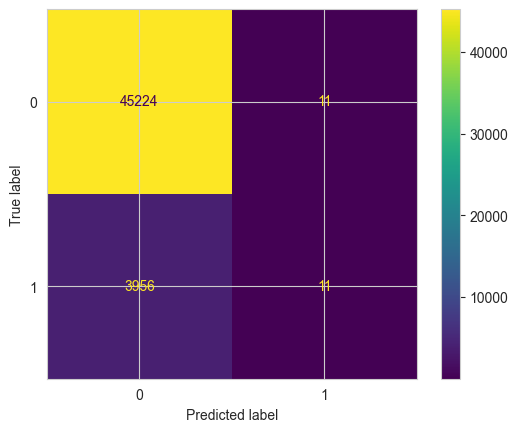

In [110]:
y_pred = best_model.predict(val_data)

conf_mat =  confusion_matrix(y_val,y_pred)
confM = ConfusionMatrixDisplay(conf_mat)
confM.plot()


# Predict unlabeled data

In [127]:
y_pred_test = best_model.predict_proba(test_data)[:,1]
app_test['TARGET'] = y_pred_test
app_test.to_csv(config.DATASET_TEST, index=False)